<a href="https://colab.research.google.com/github/makeentosch/abnormalvoice/blob/main/pytorch_model_redaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Загрузка библиотек и данных

In [ ]:
import os
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import numpy as np
import pandas as pd
import librosa

In [ ]:
!mkdir /root/.kaggle
import json
kaggle = {"username":"yanapple","key":"53c4e2d6e293bb5024208c4fdab61b4e"}
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle, f)

!chmod 600 /root/.kaggle/kaggle.json
#Загружаем данные выбранного соревнования
!kaggle datasets download mhantor/russian-voice-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
russian-voice-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! unzip russian-voice-dataset

Archive:  russian-voice-dataset.zip
replace Disorder Voices/Disorder Voices/1.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


#Предобработка данных

Вариации расчета кратковременной энергии.

Если длина шага равна размеру окна, то накладывания нет, иначе разница между фреймами составит их разность - количество уникальных фреймов между двумя.

In [ ]:
def short_time_energy_2(signal): #просто иной способ рассчета длины шага и длины фрейма
  frame_length = int(10 * 22050 / 1000)
  frame_step = int(4 * 22050 / 1000)
  # framed_signal = np.array([signal[i:i+frame_length] for i in range(0, len(signal)-frame_length, frame_step)])
  framed_signal = librosa.util.frame(x=signal, frame_length=frame_length, axis=0, hop_length=frame_step )
  energy = np.sum(framed_signal**2,axis=1)
  return framed_signal

In [ ]:
def short_time_energy_1(signal): #без накладывания "окна" (наложение окна позволяет избежать неких "лепестков" на концах графика. Применяется в ненакладываемых фреймах)
  frame_length = 10
  frame_step = 10
  framed_signal = librosa.util.frame(x=signal, frame_length=frame_length, axis=0, hop_length=frame_step )
  energy = np.sum(framed_signal**2,axis=1)
  return energy

In [ ]:

def short_time_energy_0(signal): #так называемое overlapping фреймирование, с наложением след идущих кадров с предыдущими
  frame_length = 10
  frame_step = 4
  w = []
  framed_signal = librosa.util.frame(x=signal, frame_length=frame_length, axis=0, hop_length=frame_step ) #frame_length=9 - по 21мс каждый фрейм, наложение кадров
  for frame in framed_signal:
    window_frames = []
    for n in frame:
      window_elem = 0.54 - 0.46 * np.cos(2 * np.pi * n / (frame_length - 1))
      window_frames.append(window_elem)
    w.append(window_frames)
  energy = np.sum(np.matmul(framed_signal, np.transpose(w))**2,axis=1)
  return energy

  # for i, fr in enumerate(framed_signal):
  # energy.append(np.sum(filters.get_window(fr, frame_length, fftbins=True))**2)

In [ ]:
def short_time_energy(signal): #без overlapping, но с окном
  frame_length = 9
  w = []
  framed_signal = librosa.util.frame(x=signal, frame_length=frame_length, axis=0, hop_length=frame_length)
  for frame in framed_signal:
    window_frames = []
    for n in frame:
      window_elem = 0.54 - 0.46 * np.cos(2 * np.pi * n / (frame_length - 1))
      window_frames.append(window_elem)
    w.append(window_frames)
  energy = np.sum(np.matmul(framed_signal, np.transpose(w))**2,axis=1)
  return energy

In [ ]:

file = pd.read_excel('/content/Speeches.xlsx')
y = [sentence for sentence in file['Русская речь']]

dir_name = "/content/Disorder Voices/Disorder Voices/"
files_in_dir = os.listdir(dir_name)

X = []
i = 1

for e in range(1, 2001):
    file_name = f'{e}.wav'
    sampl = librosa.load(dir_name + file_name, sr=22050)[0]
    # sampl = sampl[np.newaxis, :]
    X.append(torch.Tensor(sampl))
    if i % 100 == 0:
        print(i)
    i += 1

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000


In [ ]:
print(len(X[3]))
energ_1 = short_time_energy_1(X[3])
print(len(energ_1))
energ = short_time_energy(X[3])
energ_0 = short_time_energy_0(X[3])

37742
3774


Text(0.5, 1.0, 'Speech Signal')

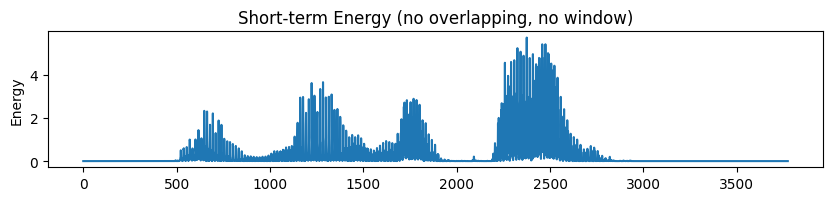

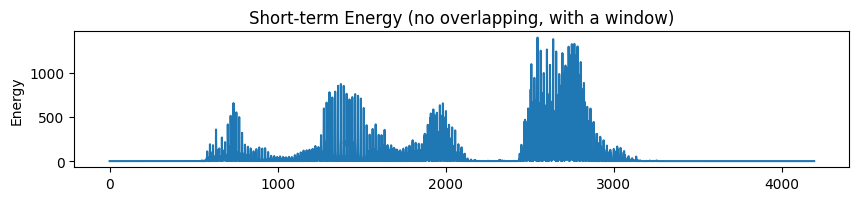

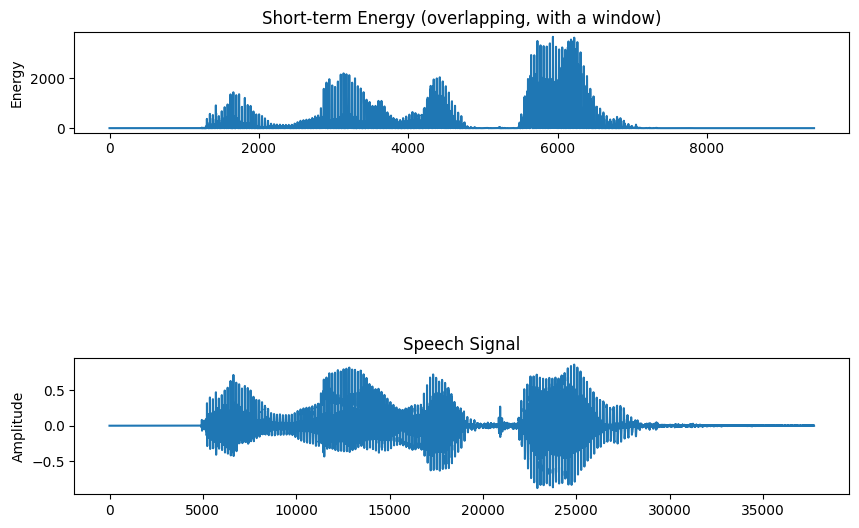

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(energ_1)
plt.ylabel('Energy')
plt.title('Short-term Energy (no overlapping, no window)')

plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 2)
plt.plot(energ)
plt.ylabel('Energy')
plt.title('Short-term Energy (no overlapping, with a window)')

plt.figure(figsize=(10, 6))
plt.subplot(4, 1, 1)
plt.plot(energ_0)
plt.ylabel('Energy')
plt.title('Short-term Energy (overlapping, with a window)')

plt.subplot(3, 1, 3)
plt.plot(X[3])
plt.ylabel('Amplitude')
plt.title('Speech Signal')

Далее работа ведется с no overlapping with a window STE (short time energy).

The filter coefficient α determines the degree of smoothing applied to the energy values, with smaller values resulting in more smoothing.

In [ ]:
from logging import raiseExceptions

def low_pass_filter(energy, coef):
  smoothed_energ = []
  if 0 > coef or 1 < coef:
    raise ValueError('Коэффициент coef должен быть в диапазоне от 0 до 1')
  for n in range(len(energy)):
    if n == 0: y = coef*energy[n]
    else: y = coef*energy[n]+(1-coef)*energy[n-1]
    smoothed_energ.append(y)
  return smoothed_energ

In [ ]:
smoothed_ste = low_pass_filter(energy=energ, coef=0.5)

Text(0.5, 1.0, 'initial STE')

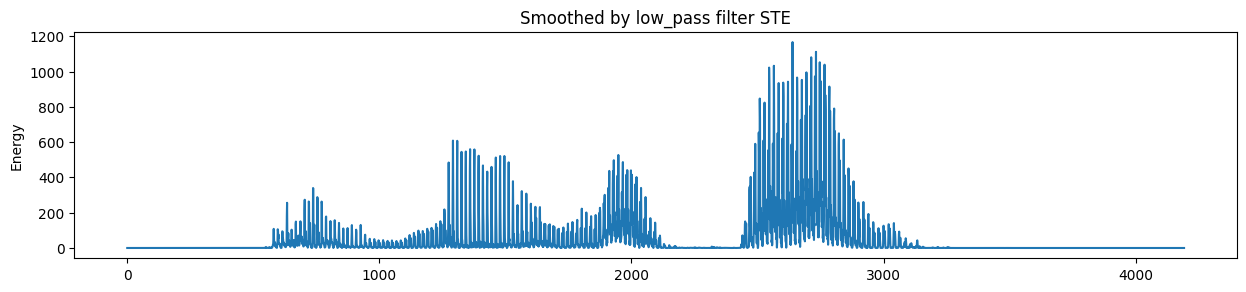

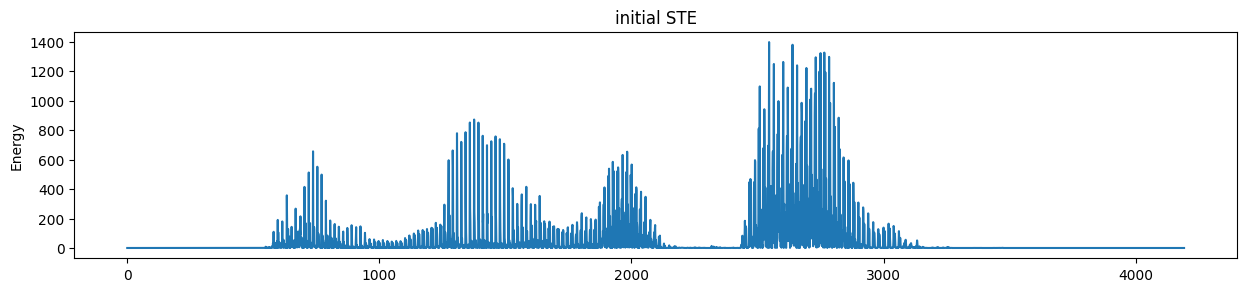

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 2)
plt.plot(smoothed_ste)
plt.ylabel('Energy')
plt.title('Smoothed by low_pass filter STE')

plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 2)
plt.plot(energ)
plt.ylabel('Energy')
plt.title('initial STE')

https://pytorch.org/docs/stable/generated/torch.nn.Threshold.html

In [ ]:
def threshold_applied(smoothed_energy, threshold=20):
   smoothed_energy = torch.tensor(smoothed_energy)
   thresholded_ste = torch.threshold(input=smoothed_energy, threshold=threshold, value=0)
   return thresholded_ste

In [ ]:
threshold_ste = threshold_applied(smoothed_ste)

Text(0.5, 1.0, 'Smoothed by low_pass filter STE')

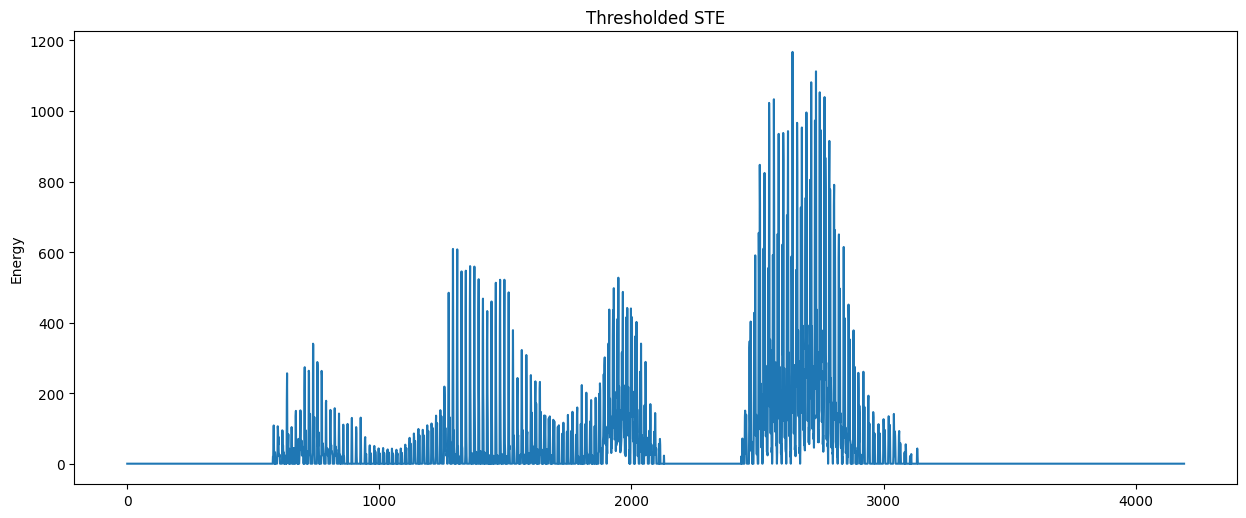

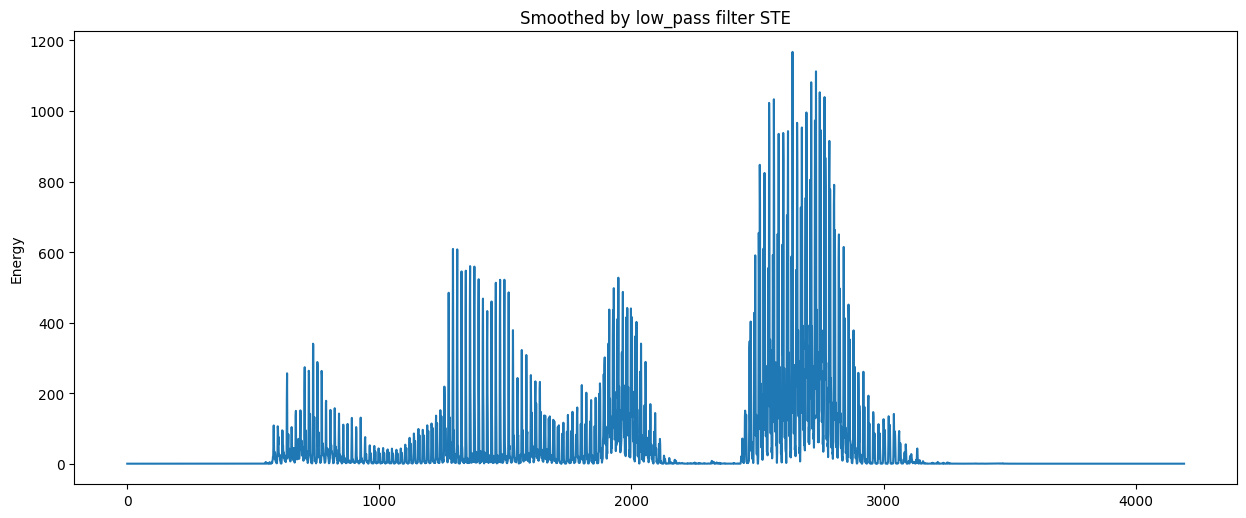

In [ ]:
plt.figure(figsize=(15, 20))
plt.subplot(3, 1, 2)
plt.plot(threshold_ste)
plt.ylabel('Energy')
plt.title('Thresholded STE')

plt.figure(figsize=(15, 20))
plt.subplot(3, 1, 2)
plt.plot(smoothed_ste)
plt.ylabel('Energy')
plt.title('Smoothed by low_pass filter STE')

Здесь проходит предобработка фраз, не трогать

In [ ]:
char_map = {"а": 0, "б": 1, "в": 2, "г": 3, "д": 4, "е": 5, "ё": 6, "ж": 7, "з": 8, "и": 9, "й": 10,
            "к": 11, "л": 12, "м": 13, "н": 14, "о": 15, "п": 16, "р": 17, "с": 18, "т": 19, "у": 20,
            "ф": 21, "ч": 22, "ц": 23, "ш": 24, "щ": 25, "ъ": 26, "ы": 27, "ь": 28, "э": 29, "ю": 30,
            "я": 31, "х": 32, " ": 33}

def remove_characters(sentence):
    sentence = sentence.lower()
    sentence = ''.join(filter(lambda x: x in char_map, sentence))
    return sentence

y = list(map(remove_characters, y))

In [ ]:
len(y)

2000

In [ ]:
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)

valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

def data_processing(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, utterance) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        elif data_type == 'valid':
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            raise Exception('data_type should be train or valid')
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance))
        labels.append(label)
        input_lengths.append(spec.shape[0]//4)
        label_lengths.append(len(label))

    spectrograms1 = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)

    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms1, labels, input_lengths, label_lengths

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


#WER, CER, leventain distance + кодирование и декодирование

In [ ]:
def avg_wer(wer_scores, combined_ref_len):
    return float(sum(wer_scores)) / float(combined_ref_len)


def _levenshtein_distance(ref, hyp):
    """Levenshtein distance is a string metric for measuring the difference
    between two sequences. Informally, the levenshtein disctance is defined as
    the minimum number of single-character edits (substitutions, insertions or
    deletions) required to change one word into the other. We can naturally
    extend the edits to word level when calculate levenshtein disctance for
    two sentences.
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in word-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Levenshtein distance and word number of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)


def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    """Compute the levenshtein distance between reference sequence and
    hypothesis sequence in char-level.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Levenshtein distance and length of reference sentence.
    :rtype: list
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)


def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculate word error rate (WER). WER compares reference text and
    hypothesis text in word-level. WER is defined as:
    .. math::
        WER = (Sw + Dw + Iw) / Nw
    where
    .. code-block:: text
        Sw is the number of words subsituted,
        Dw is the number of words deleted,
        Iw is the number of words inserted,
        Nw is the number of words in the reference
    We can use levenshtein distance to calculate WER. Please draw an attention
    that empty items will be removed when splitting sentences by delimiter.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param delimiter: Delimiter of input sentences.
    :type delimiter: char
    :return: Word error rate.
    :rtype: float
    :raises ValueError: If word number of reference is zero.
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)

    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer


def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculate charactor error rate (CER). CER compares reference text and
    hypothesis text in char-level. CER is defined as:
    .. math::
        CER = (Sc + Dc + Ic) / Nc
    where
    .. code-block:: text
        Sc is the number of characters substituted,
        Dc is the number of characters deleted,
        Ic is the number of characters inserted
        Nc is the number of characters in the reference
    We can use levenshtein distance to calculate CER. Chinese input should be
    encoded to unicode. Please draw an attention that the leading and tailing
    space characters will be truncated and multiple consecutive space
    characters in a sentence will be replaced by one space character.
    :param reference: The reference sentence.
    :type reference: basestring
    :param hypothesis: The hypothesis sentence.
    :type hypothesis: basestring
    :param ignore_case: Whether case-sensitive or not.
    :type ignore_case: bool
    :param remove_space: Whether remove internal space characters
    :type remove_space: bool
    :return: Character error rate.
    :rtype: float
    :raises ValueError: If the reference length is zero.
    """
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer

class TextTransform:
    """Maps characters to integers and vice versa"""
    def __init__(self):
        self.char_map = {"а": 0, "б": 1, "в": 2, "г": 3, "д": 4, "е": 5, "ё": 6, "ж": 7, "з": 8, "и": 9, "й": 10,
                  "к": 11, "л": 12, "м": 13, "н": 14, "о": 15, "п": 16, "р": 17, "с": 18, "т": 19, "у": 20,
                  "ф": 21, "ч": 22, "ц": 23, "ш": 24, "щ": 25, "ъ": 26, "ы": 27, "ь": 28, "э": 29, "ю": 30,
                  "я": 31, "х": 32, " ": 33}

        self.index_map = {}
        for key, value in self.char_map.items():
            self.index_map[value] = key

    def text_to_int(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c != '':
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, labels):
        """ Use a character map and convert integer labels to an text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string)

text_transform = TextTransform()

def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
    arg_maxes = torch.argmax(output, dim=2)
    decodes = []
    targets = []
    for i, args in enumerate(arg_maxes):
        decode = []
        targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
        for j, index in enumerate(args):
            if index != blank_label:
                if collapse_repeated and j != 0 and index == args[j -1]:
                    continue
                decode.append(index.item())
        decodes.append(text_transform.int_to_text(decode))
    return decodes, targets

#Модель

In [ ]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time)


class ResidualCNN(nn.Module):
    """Residual CNN inspired by https://arxiv.org/pdf/1603.05027.pdf
        except with layer norm instead of batch norm
    """
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)


class BidirectionalGRU(nn.Module):

    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x


class SpeechRecognitionModel(nn.Module):

    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats)
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [ ]:
from torch.utils.data import Dataset

class AudioDataset(Dataset):
    def __init__(self, audio_list, text_list):
        self.audio_list = audio_list
        self.text_list = text_list

    def __len__(self):
        return len(self.text_list)

    def __getitem__(self, index):
        audio = self.audio_list[index]
        text = self.text_list[index]
        return audio, text

In [ ]:
class SpeechRecognitionModel1(nn.Module):
    def __init__(self, num_classes):
        super(SpeechRecognitionModel1, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
            nn.Conv2d(64, 128, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.Conv2d(128, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.Conv2d(64, 64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.GELU(),
            nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),
        )

        self.rnn = nn.GRU(input_size=2048,
                    hidden_size=256,
                    num_layers=1,
                    batch_first=True,
                    bidirectional=True)

        self.fc = nn.Sequential(
            nn.Linear(512, 128),
            nn.GELU(),
            nn.Linear(128, num_classes),
        )
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.conv(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(x.size(0), x.size(1), -1)
        x, _ = self.rnn(x)
        x = self.fc(x)
        x = self.softmax(x)
        return x

"""nn.Linear(512, 128),
            nn.GELU(),
            nn.Dropout(0.35),"""

'nn.Linear(512, 128),\n            nn.GELU(),\n            nn.Dropout(0.35),'

#Процесс обучения модели - кастомный

In [ ]:
class IterMeter(object):
    """keeps track of total iterations"""
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val


def train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter):
    model.train()
    data_len = len(train_loader.dataset)
    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(spectrograms)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()

        optimizer.step()
        scheduler.step()
        iter_meter.step()
        if batch_idx % 10 == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, criterion, epoch, iter_meter):
    print('\nevaluating...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with torch.no_grad():
        for i, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            output = model(spectrograms)  # (batch, time, n_class)
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)

            loss = criterion(output, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)

            decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
            for j in range(len(decoded_preds)):
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)

    print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))


def main(learning_rate=5e-4, batch_size=20, epochs=10):

    hparams = {
        "n_cnn_layers": 2,
        "n_rnn_layers": 2,
        "rnn_dim": 256,
        "n_class": 34,
        "n_feats": 128,
        "stride":2,
        "dropout": 0.1,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
    }

    use_cuda = torch.cuda.is_available()
    torch.manual_seed(7)
    device = torch.device("cuda" if use_cuda else "cpu")

    train_dataset = AudioDataset(X_train, y_train)
    test_dataset = AudioDataset(X_test, y_test)

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = data.DataLoader(dataset=train_dataset,
                                batch_size=hparams['batch_size'],
                                shuffle=True,
                                collate_fn=lambda x: data_processing(x, 'train'),
                                **kwargs)
    test_loader = data.DataLoader(dataset=test_dataset,
                                batch_size=hparams['batch_size'],
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x, 'valid'),
                                **kwargs)

    model = SpeechRecognitionModel1(34).to(device)
    """model = SpeechRecognitionModel(
        hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
        hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
        ).to(device)"""

    print(model)
    print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

    optimizer = optim.AdamW(model.parameters(), hparams['learning_rate'])
    criterion = nn.CTCLoss(blank=28).to(device)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=hparams['learning_rate'],
                                            steps_per_epoch=int(len(train_loader)),
                                            epochs=hparams['epochs'],
                                            anneal_strategy='linear')

    iter_meter = IterMeter()
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, criterion, optimizer, scheduler, epoch, iter_meter)
        test(model, device, test_loader, criterion, epoch, iter_meter)

In [ ]:
learning_rate = 0.001
batch_size = 10
epochs = 250

main(learning_rate, batch_size, epochs)

SpeechRecognitionModel1(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): GELU(approximate='none')
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): GELU(approximate='none')
    (7): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): GELU(approximate='none')
    (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): GELU(approximate='none')
    (12): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (rnn): GRU(2048, 256, batch_first=True, bidirection

KeyboardInterrupt: ignored